In [943]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import genfromtxt
import numpy as np
import math
import scipy.stats
import random
import scipy
import networkx as nx
import copy
import community

In [556]:
import sklearn
from sklearn.cluster import SpectralClustering

In [868]:
def Cooper_Barahona(A,kmax,alpha=0.9):
    
    '''Takes adjacency matrix A and returns the similarity matrix Y
    of the flow profiles of each node according to the method of
    Cooper and Barahona'''
    
    N = len(A)                                  # number of nodes
    lambda1 = max(np.linalg.eigvals(A))         # largest e-value
    beta = alpha/lambda1

    At = np.transpose(A)
    X = At.copy()
    I = np.ones((N,1))
    X = beta*np.matmul(X,I)


    for k in range(2,kmax+1):
        X = np.concatenate((X,(beta**k)*np.matmul(np.linalg.matrix_power(At,k),I)),axis=1)
    
    for k in range(1,kmax+1):
        X = np.concatenate((X,(beta**k)*np.matmul(np.linalg.matrix_power(A,k),I)),axis=1)

    Y = np.zeros((N,N))

    for i in range(N):
        Y[i] = [(1 - scipy.spatial.distance.cosine(X[i],X[j])) for j in range(N)]
    
    return Y

In [804]:
def L_H_N(G,alpha=0.97):
    
    '''Takes graph G and returns similarity matrix S
    of the nodes according to Leicht, Holme and Newman's
    definition of similarity'''
    
    n = G.number_of_nodes()
    m = G.number_of_edges()
    A = nx.convert_matrix.to_numpy_matrix(G)          #adjacency matrix
    lambda1 = np.real(max(np.linalg.eigvals(A)))      #largest e-value
    degrees = list(G.degree)
    degrees = [degrees[i][1] for i in range(len(degrees))]
    D = np.diag(degrees)
    Dinv = np.linalg.inv(D)
    M = np.identity(n) - (alpha/lambda1)*A
    Minv = np.linalg.inv(M)

    S = 2*m*lambda1*np.matmul(np.matmul(Dinv,Minv),Dinv)
    
    return S 

In [226]:
def spectral_clustering(S,n_clusts):
    
    clustering = SpectralClustering(n_clusters=n_clusts,assign_labels="discretize",
                                    affinity='precomputed').fit(S)
    
    partition = [[] for i in range(n_clusts)]

    for i in range(len(clustering.labels_)):
        partition[clustering.labels_[i]].append(i)
    
    return partition

In [1008]:
def Visualise_roles(G,partition,order=None,spacing=0.3,labelheight=0.3,labels=None): #reference PS3
    
    '''Takes a graph and a partition of its nodes into classes
    (as a list of lists of nodes in each class) and displays the
    classes separately and in different colours'''
    
    if order is None:
        order = list(range(len(partition)))
    
    plt.figure (figsize=(7,7))
    
    size = len(partition)
    
    #This line of code is from the solutions to PS3
    cm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Paired'),
                               norm=mpl.colors.Normalize(vmin=0, vmax=float(size),
                                                         clip=False))
    
    C = [nx.circular_layout(G.subgraph(partition[i])) for i in order]
    
    #separating the classes in the partition
    
    for i in range(1,size):
        d = spacing + max([y for x,y in C[i].values()]) - min([y for x,y in C[i-1].values()])
    
        for j in C[i].keys():
            C[i][j][1] = C[i][j][1] - d
    
    pos = {}
    
    for i in range(size):
        pos.update(C[i])
    
    #This loop is from the solutions to PS3
    count = 0
    for i in range(size):
        count = count + 1.
        nx.draw_networkx_nodes(G, pos, partition[i], node_size=60, node_color=[cm.to_rgba(count)])

    nx.draw_networkx_edges(G, pos, alpha=0.2, width = 0.5)
    
    for i in pos.keys(): #making labels above nodes
        pos[i][1] += labelheight
    
    if labels is None:
        pos2 = pos
    else:
        pos2 = copy.copy(labels)
        pos2 = {value:key for key, value in pos2.items()}

        j = 0
        for i in pos2.keys():
            pos2[i] = pos[j]
            j += 1
        
        nx.relabel_nodes(G, labels, copy=False)

    nx.draw_networkx_labels(G, pos2)
    
    plt.show()
    return partition

In [1034]:
def Visualise(G,partition,labelheight=0.3):
    
    '''Takes a graph and a partition of its nodes into classes and displays the
    classes in different colours'''
    
    plt.figure (figsize=(6,6))
    
    size = len(partition)
    
    #This line of code is from the solutions to PS3
    cm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Paired'),
                               norm=mpl.colors.Normalize(vmin=0, vmax=float(size),
                                                         clip=False))
    
    pos = nx.spring_layout(G)
    
    #This loop is from the solutions to PS3
    count = 0
    for i in range(size):
        count = count + 1.
        nx.draw_networkx_nodes(G, pos, partition[i], node_size=60, node_color=[cm.to_rgba(count)])

    nx.draw_networkx_edges(G, pos, alpha=0.2, width = 0.5)
    
    for i in pos.keys(): #making labels above nodes
        pos[i][1] += labelheight
    
    nx.draw_networkx_labels(G, pos)
    plt.show()
    return partition

In [729]:
def Qstar(G,partition):
    
    '''Takes a graph and a partition of its nodes and calculates Q*
    as defined by Reichardt and White'''
    
    M = G.number_of_edges()
    A = nx.convert_matrix.to_numpy_matrix(G)     #adjacency matrix
    A = np.asarray(A)
    q = len(partition)       #number of classes in partition
    
    if nx.classes.function.is_directed(G) is True:
        in_degs = list(dict(G.in_degree()).values())        
        out_degs = list(dict(G.out_degree()).values())
    else:
        in_degs = list(dict(G.degree()).values())        
        out_degs = list(dict(G.degree()).values())
    
    K_ins = [0]*q
    for r in range(q):
        K_ins[r] = sum([in_degs[j] for j in partition[r]])
        
    K_outs = [0]*q
    for r in range(q):
        K_outs[r] = sum([out_degs[j] for j in partition[r]])
        
    S = [[0]*q]*q
    
    for r in range(q):
        for s in range(q):
            S[r][s] = sum([sum([A[i][j] for j in partition[s]]) for i in partition[r]])
            
    for r in range(q):
        S[r][r] = S[r][r] - sum(A[i][i] for i in partition[r])
        
    Q = 0.5*sum([sum([(1/M**2)*abs(M*S[r][s] - (K_outs[r]*K_ins[s])) for s in range(q)]) for r in range(q)])
    
    return Q

Fig. 6.

In [811]:
P = [[0,0.9,0],[0,0.4,0.9],[0,0,0]]
G = nx.stochastic_block_model([6,6,6], P, directed=True)

A = nx.convert_matrix.to_numpy_matrix(G)
S = Cooper_Barahona(A,0.97,4)
partition = spectral_clustering(S,3)

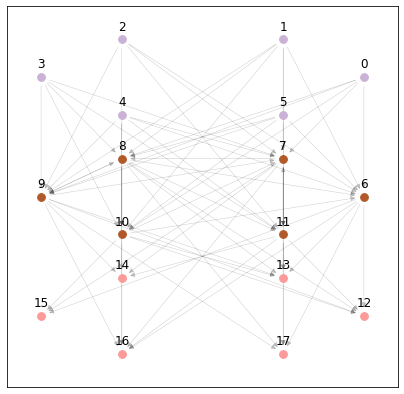

[[12, 13, 14, 15, 16, 17], [0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11]]

In [812]:
Visualise_roles(G,partition,order=[1,2,0],spacing = 1)

Fig. 12.

In [1004]:
#note we've relabelled nodes to be integers not strings and taken away 1 so start at zero

G = nx.readwrite.edgelist.read_weighted_edgelist('/Users/willshardlow/Desktop/StMarks.paj.txt',
                                                 nodetype=int,create_using=nx.DiGraph())
n = G.number_of_nodes()

a = [(i+1,i) for i in range(n)]

mapping = dict(a)

nx.relabel_nodes(G, mapping, copy=False)

A = nx.convert_matrix.to_numpy_matrix(G)
S = Cooper_Barahona(A,50)
partition = spectral_clustering(S,4)

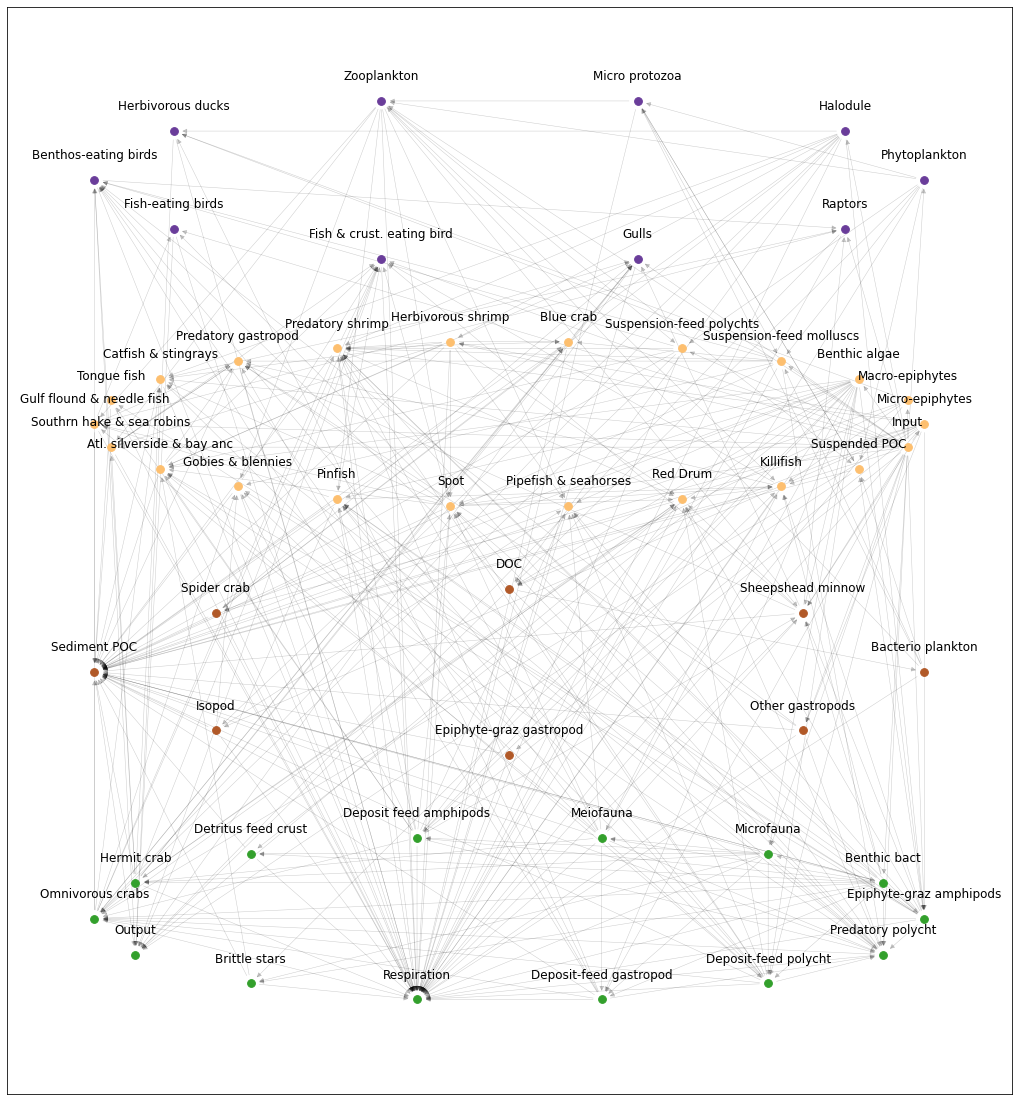

[[8, 11, 12, 13, 14, 15, 16, 18, 21, 24, 25, 26, 52, 53],
 [2,
  3,
  4,
  9,
  10,
  19,
  22,
  23,
  27,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  40,
  41,
  49,
  51],
 [0, 1, 6, 7, 42, 43, 44, 45, 46, 47],
 [5, 17, 20, 28, 29, 39, 48, 50]]

In [1007]:
G = nx.readwrite.edgelist.read_weighted_edgelist('/Users/willshardlow/Desktop/StMarks.paj.txt',
                                                 nodetype=int,create_using=nx.DiGraph())
n = G.number_of_nodes()

a = [(i+1,i) for i in range(n)]

mapping = dict(a)

nx.relabel_nodes(G, mapping, copy=False)
Visualise_roles(G,partition,spacing=1,labels=D,order=[2,1,3,0])

In [1001]:
D = {1 :"Phytoplankton",
   2 :"Halodule",
   3 :"Micro-epiphytes",
   4 :"Macro-epiphytes",
   5 :"Benthic algae",
   6 :"Bacterio plankton",
   7 :"Micro protozoa",
   8 :"Zooplankton",
   9 :"Epiphyte-graz amphipods",
  10 :"Suspension-feed molluscs",
  11 :"Suspension-feed polychts",
  12 :"Benthic bact",
  13 :"Microfauna",
  14 :"Meiofauna",
  15 :"Deposit feed amphipods",
  16 :"Detritus feed crust",
  17 :"Hermit crab",
  18 :"Spider crab",
  19 :"Omnivorous crabs",
  20 :"Blue crab",
  21 :"Isopod",
  22 :"Brittle stars",
  23 :"Herbivorous shrimp",
  24 :"Predatory shrimp",
  25 :"Deposit-feed gastropod",
  26 :"Deposit-feed polycht",
  27 :"Predatory polycht",
  28 :"Predatory gastropod",
  29 :"Epiphyte-graz gastropod",
  30 :"Other gastropods",
  31 :"Catfish & stingrays",
  32 :"Tongue fish",
  33 :"Gulf flound & needle fish",
  34 :"Southrn hake & sea robins",
  35 :"Atl. silverside & bay anc",
  36 :"Gobies & blennies",
  37 :"Pinfish",
  38 :"Spot",
  39 :"Pipefish & seahorses",
  40 :"Sheepshead minnow",
  41 :"Red Drum",
  42 :"Killifish",
  43 :"Herbivorous ducks",
  44 :"Benthos-eating birds",
  45 :"Fish-eating birds",
  46 :"Fish & crust. eating bird",
  47 :"Gulls",
  48 :"Raptors",
  49 :"DOC",
  50 :"Suspended POC",
  51 :"Sediment POC",
  52 :"Input",
  53 :"Output",
  54 :"Respiration"}

for i in range(1,55):
    D[i-1] = D.pop(i)

Fig. 4.

In [973]:
P = [[1/2,1/10,1/25,1/50,1/100],[1/10,1/2,1/10,1/25,1/50],
    [1/25,1/10,1/2,1/10,1/25],[1/50,1/25,1/10,1/2,1/10],
    [1/100,1/50,1/25,1/10,1/2]]

G = nx.stochastic_block_model([10,10,10,10,10], P, directed=False)

S = L_H_N(G)
partition = spectral_clustering(S,5)

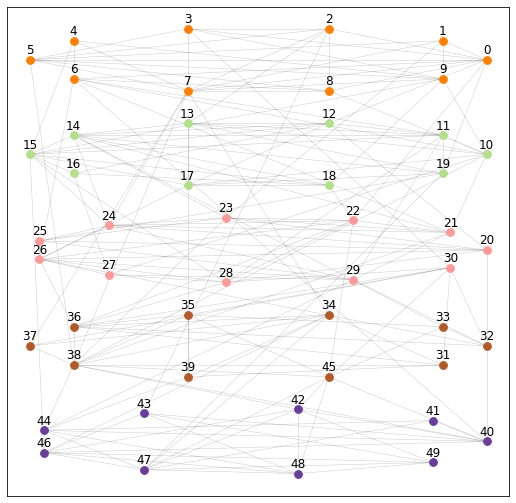

[[10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [40, 41, 42, 43, 44, 46, 47, 48, 49],
 [31, 32, 33, 34, 35, 36, 37, 38, 39, 45]]

In [975]:
Visualise_roles(G,partition,spacing=1,order=[2,0,1,4,3])

Fig. 13.

Fig. 10.

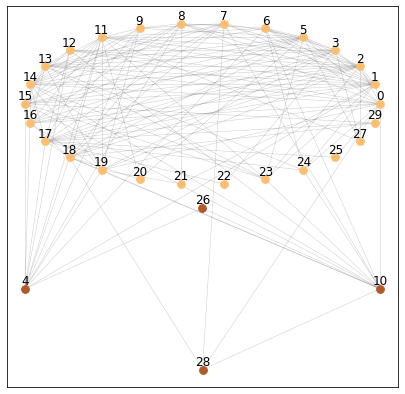

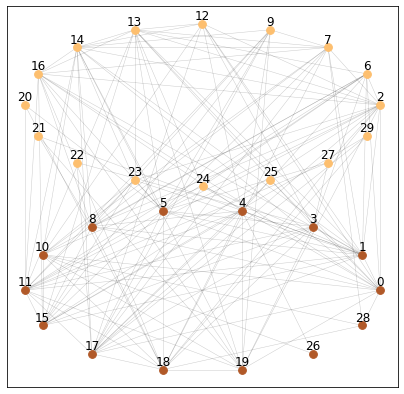

[[2, 6, 7, 9, 12, 13, 14, 16, 20, 21, 22, 23, 24, 25, 27, 29],
 [0, 1, 3, 4, 5, 8, 10, 11, 15, 17, 18, 19, 26, 28]]

In [1011]:
p = [[0.6,0.2],[0.2,0]]

G = nx.stochastic_block_model([20,10], p, directed=False)

A = nx.convert_matrix.to_numpy_matrix(G)

S1 = L_H_N(G)
S2 = Cooper_Barahona(A,10)
partition1 = spectral_clustering(S1,2)
partition2 = spectral_clustering(S2,2)
Visualise_roles(G,partition1,labelheight=0.1)
Visualise_roles(G,partition2,labelheight=0.1)

Fig. 8. (Plotting)

(Code based on https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html)

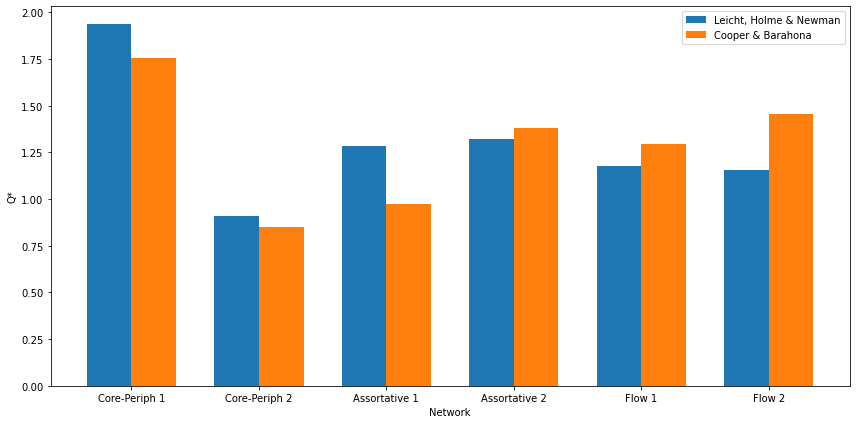

In [942]:
x = np.arange(1,7)
width = 0.35 

fig, ax = plt.subplots(figsize = (12,6))
rects1 = ax.bar(x - width/2, LHNQstars, width, label='Leicht, Holme & Newman')
rects2 = ax.bar(x + width/2, CoopBaraQstars, width, label ='Cooper & Barahona')

ax.set_xlabel('Network')
ax.set_ylabel('Q*')
ax.set_xticks(x)
ax.set_xticklabels(titles)
ax.legend()

fig.tight_layout()

plt.show()

Fig. 7.

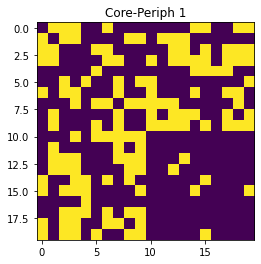

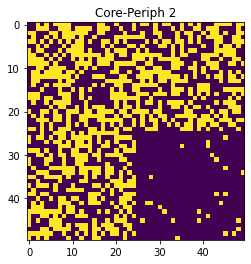

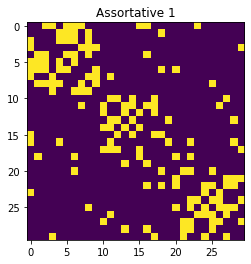

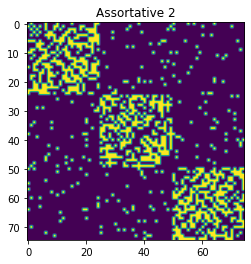

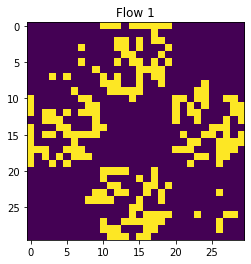

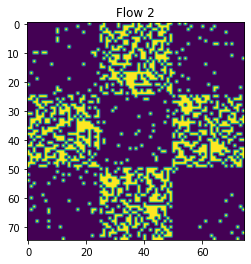

In [939]:
titles = ['Core-Periph 1','Core-Periph 2','Assortative 1','Assortative 2','Flow 1','Flow 2']

for i in range(6):

    plt.imshow(As[i])
    plt.title(titles[i])
    plt.show()

Fig. 8. (Results)

In [936]:
reps = 50

Ps = [0]*3
Ps[0] = [[0.5,0.5],[0.5,0.05]]
Ps[1] = [[0.5,0.05,0.05],[0.05,0.5,0.05],[0.05,0.05,0.5]]
Ps[2] = [[0.05,0.5,0.05],[0.5,0.05,0.5],[0.05,0.5,0.05]]

Gs = [0]*6
As = [0]*6

CoopBaraPartitions = [0]*6
LHNPartitions = [0]*6
CoopBaraQstars = [0]*6
LHNQstars = [0]*6

CBavs = [0]*reps
LHNavs = [0]*reps

for j in range(reps):

    Gs[0] = nx.stochastic_block_model([10,10], Ps[0], directed=False)
    Gs[1] = nx.stochastic_block_model([25,25], Ps[0], directed=False)

    Gs[2] = nx.stochastic_block_model([10,10,10], Ps[1], directed=False)
    Gs[3] = nx.stochastic_block_model([25,25,25], Ps[1], directed=False)

    Gs[4] = nx.stochastic_block_model([10,10,10], Ps[2], directed=False)
    Gs[5] = nx.stochastic_block_model([25,25,25], Ps[2], directed=False)

    As = [nx.convert_matrix.to_numpy_matrix(Gs[i]) for i in range(6)]

    CoopBaraPartitions[0] = spectral_clustering( Cooper_Barahona(As[0],25) , 2)
    CoopBaraPartitions[1] = spectral_clustering( Cooper_Barahona(As[1],25) , 2)
    CoopBaraQstars[0] = Qstar(Gs[0],CoopBaraPartitions[0])
    CoopBaraQstars[1] = Qstar(Gs[1],CoopBaraPartitions[1])

    LHNPartitions[0] = spectral_clustering( L_H_N(Gs[0]) , 2)
    LHNPartitions[1] = spectral_clustering( L_H_N(Gs[1]) , 2)
    LHNQstars[0] = Qstar(Gs[0],LHNPartitions[0])
    LHNQstars[1] = Qstar(Gs[1],LHNPartitions[1])


    for i in range(2,6):
        CoopBaraPartitions[i] = spectral_clustering( Cooper_Barahona(As[i],25) , 3)
        LHNPartitions[i] = spectral_clustering( L_H_N(Gs[i]) , 3)
        CoopBaraQstars[i] = Qstar(Gs[i],CoopBaraPartitions[i])
        LHNQstars[i] = Qstar(Gs[i],LHNPartitions[i])
        
    CBavs[j] = CoopBaraQstars
    LHNavs[j] = LHNQstars
    
for j in range(6):
    CoopBaraQstars[j] = sum([CBavs[i][j] for i in range(reps)])/reps
    LHNQstars[j] = sum([LHNavs[i][j] for i in range(reps)])/reps

Fig. 9.

(First two lines of code from: https://stackoverflow.com/questions/29572623/plot-networkx-graph-from-adjacency-matrix-in-csv-file)

Just Visualise algorithm code which has been slightly adapted to have the same node layout for the two partitions.

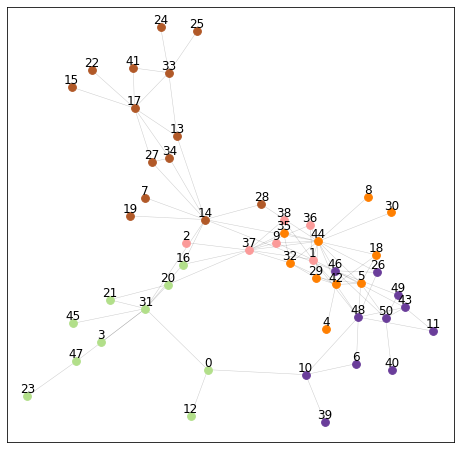

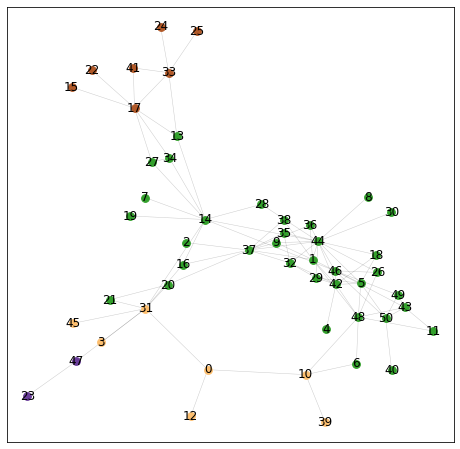

In [988]:
mydata = genfromtxt('/Users/willshardlow/Desktop/COCAINE_JUANES.csv', delimiter=',')
A = mydata[1:,1:]
A = np.matrix(A)

G = nx.convert_matrix.from_numpy_matrix(A)
n = G.number_of_nodes()
par = community.best_partition(G)

partition = [[] for i in range(5)]

for i in range(n):
    partition[par[i]].append(i)

labelheight = 0.03

    
plt.figure (figsize=(8,8))
    
size = len(partition)
    
cm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Paired'),
                               norm=mpl.colors.Normalize(vmin=0, vmax=float(size),
                                                         clip=False))
    
pos = nx.spring_layout(G)
    
count = 0
for i in range(size):
    count = count + 1.
    nx.draw_networkx_nodes(G, pos, partition[i], node_size=60, node_color=[cm.to_rgba(count)])

nx.draw_networkx_edges(G, pos, alpha=0.2, width = 0.5)
    
for i in pos.keys(): #making labels above nodes
    pos[i][1] += labelheight
    
nx.draw_networkx_labels(G, pos)
plt.show()


for i in pos.keys(): 
        pos[i][1] -= labelheight
        
pos2 = copy.copy(pos)

S = L_H_N(G)
LHNpart = spectral_clustering(S,4)
    
    
    
plt.figure (figsize=(8,8))

size = len(LHNpart)
    
cm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Paired'),
                               norm=mpl.colors.Normalize(vmin=0, vmax=float(size),
                                                         clip=False))
    
count = 0
for i in range(size):
    count = count + 1.
    nx.draw_networkx_nodes(G, pos2, LHNpart[i], node_size=60, node_color=[cm.to_rgba(count)])

nx.draw_networkx_edges(G, pos2, alpha=0.2, width = 0.5)
    
nx.draw_networkx_labels(G, pos)
plt.show()



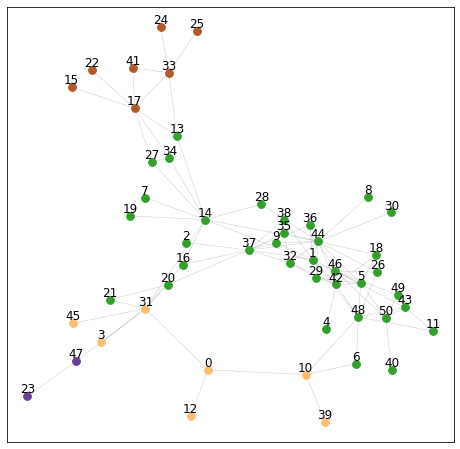

In [989]:
plt.figure (figsize=(8,8))

size = len(LHNpart)
    
cm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Paired'),
                               norm=mpl.colors.Normalize(vmin=0, vmax=float(size),
                                                         clip=False))
    
count = 0
for i in range(size):
    count = count + 1.
    nx.draw_networkx_nodes(G, pos2, LHNpart[i], node_size=60, node_color=[cm.to_rgba(count)])

nx.draw_networkx_edges(G, pos2, alpha=0.2, width = 0.5)

for i in pos.keys(): #making labels above nodes
    pos[i][1] += labelheight

nx.draw_networkx_labels(G, pos)
plt.show()

Fig. 13.

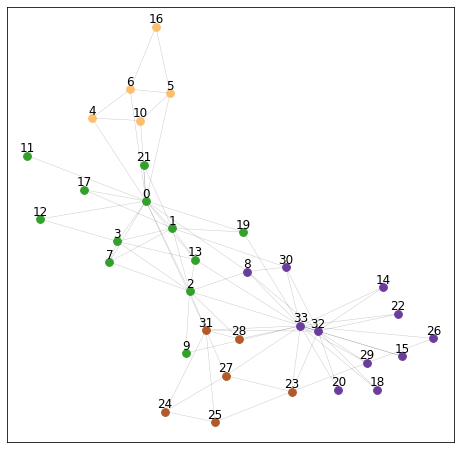

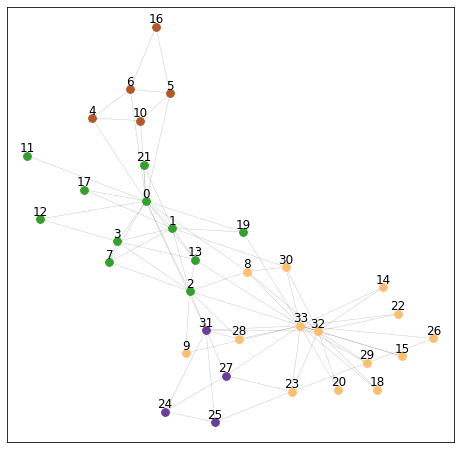

In [1016]:
G = nx.karate_club_graph()
n = G.number_of_nodes()
S = L_H_N(G)

par = community.best_partition(G)

partition = [[] for i in range(4)]

for i in range(n):
    partition[par[i]].append(i)

labelheight = 0.03

plt.figure (figsize=(8,8))
    
size = len(partition)
    
cm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Paired'),
                               norm=mpl.colors.Normalize(vmin=0, vmax=float(size),
                                                         clip=False))
    
pos = nx.spring_layout(G)
    
count = 0
for i in range(size):
    count = count + 1.
    nx.draw_networkx_nodes(G, pos, partition[i], node_size=60, node_color=[cm.to_rgba(count)])

nx.draw_networkx_edges(G, pos, alpha=0.2, width = 0.5)
    
for i in pos.keys(): #making labels above nodes
    pos[i][1] += labelheight
    
nx.draw_networkx_labels(G, pos)
plt.show()

for i in pos.keys(): 
        pos[i][1] -= labelheight
        
pos2 = copy.copy(pos)

S = L_H_N(G)
LHNpart = spectral_clustering(S,4)
    
plt.figure (figsize=(8,8))

size = len(LHNpart)
    
cm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Paired'),
                               norm=mpl.colors.Normalize(vmin=0, vmax=float(size),
                                                         clip=False))
    
count = 0
for i in range(size):
    count = count + 1.
    nx.draw_networkx_nodes(G, pos2, LHNpart[i], node_size=60, node_color=[cm.to_rgba(count)])

nx.draw_networkx_edges(G, pos2, alpha=0.2, width = 0.5)
    
for i in pos.keys(): #making labels above nodes
    pos[i][1] += labelheight
    
nx.draw_networkx_labels(G, pos)
plt.show()

Fig. 11.

(Code is just the Visualise_roles algorithm but with the layout changed)

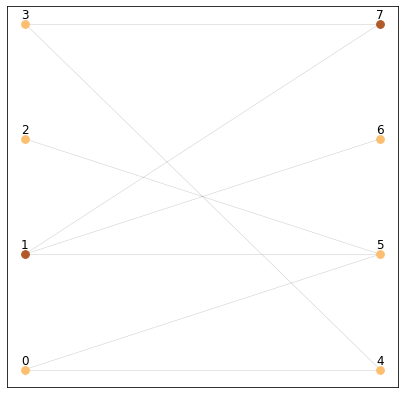

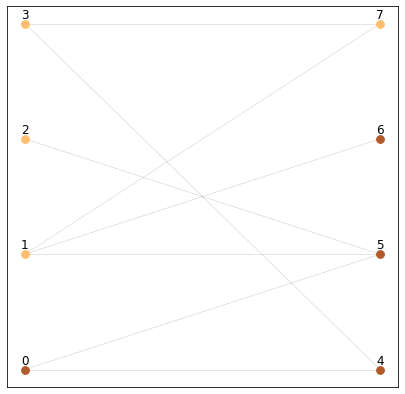

In [1057]:
G = nx.Graph()
G.add_edge(0,4)
G.add_edge(0,5)
G.add_edge(1,5)
G.add_edge(1,6)
G.add_edge(1,7)
G.add_edge(2,5)
G.add_edge(3,7)
G.add_edge(3,4)

S1 = L_H_N(G)
partition1 = spectral_clustering(S1,2)
S2 = Cooper_Barahona(nx.convert_matrix.to_numpy_matrix(G),8)
partition2 = spectral_clustering(S2,2)

labelheight = 0.04
    
plt.figure (figsize=(7,7))
    
size = len(partition1)

#This line is from the solutions to PS3
cm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Paired'),
                               norm=mpl.colors.Normalize(vmin=0, vmax=float(size),
                                                         clip=False))
    
pos = nx.drawing.layout.bipartite_layout(G,[0,1,2,3])


#This loop is from the solutions to PS3
count = 0
for i in range(size):
    count = count + 1.
    nx.draw_networkx_nodes(G, pos, partition1[i], node_size=60, node_color=[cm.to_rgba(count)])

nx.draw_networkx_edges(G, pos, alpha=0.2, width = 0.5)
    
for i in pos.keys(): #making labels above nodes
    pos[i][1] += labelheight
    
nx.draw_networkx_labels(G, pos)
plt.show()


    
plt.figure (figsize=(7,7))
    
#This line is from the solutions to PS3
cm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Paired'),
                               norm=mpl.colors.Normalize(vmin=0, vmax=float(size),
                                                         clip=False))
    
pos = nx.drawing.layout.bipartite_layout(G,[0,1,2,3])


#This loop is from the solutions to PS3    
count = 0
for i in range(size):
    count = count + 1.
    nx.draw_networkx_nodes(G, pos, partition2[i], node_size=60, node_color=[cm.to_rgba(count)])

nx.draw_networkx_edges(G, pos, alpha=0.2, width = 0.5)
    
for i in pos.keys(): #making labels above nodes
    pos[i][1] += labelheight
    
nx.draw_networkx_labels(G, pos)
plt.show()
